# Machine Learning with Spark

#### Student no : 21627868
#### Student name : Burak Yılmaz



## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

This assignment aims at trying to find out how we can detect haricot bean species, using machine learning methods with Spark Environment from the features created by digitizing the images of the various haricot beans. Our primary purpose here is to cluster and classify the data according to the types.

## Data Understanding<a class="anchor" id="data_understanding"></a>

Importing the needed libraries during execution.

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -q pyspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler,MinMaxScaler,IndexToString, StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import isnull, when, count, col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import ClusteringEvaluator,MulticlassClassificationEvaluator
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
import findspark
from sklearn.metrics import classification_report, confusion_matrix

Specify the locations of java and spark then configure it.

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"


Let's initialize the spark session and verify the session.

In [ ]:
findspark.init()
spark = SparkSession.builder.getOrCreate()
print(spark)

Load the dataset and show top 10 rows.

In [ ]:
OD = spark.read.csv('data.csv', header=True, inferSchema=True)
OD.show(10)

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|SEKER|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

OD.columns give us how many features our dataset has and OD.count() gives us how many records our dataset has.

In [ ]:
print("There are {} features".format(len(OD.columns)))
print("There are {} records".format(OD.count()))

There are 17 features
There are 13611 records


We can get statistical information of the data.


In [ ]:
OD.describe().show()

+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------+
|summary|              Area|         Perimeter|  MajorAxisLength|  MinorAxisLength|       AspectRation|       Eccentricity|        ConvexArea|     EquivDiameter|              Extent|          Solidity|          roundness|        Compactness|        ShapeFactor1|        ShapeFactor2|      ShapeFactor3|        ShapeFactor4|   Class|
+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------+
|

Let's check each column data types. Except the class feature all features are numeric.

In [ ]:
OD.dtypes

[('Area', 'int'),
 ('Perimeter', 'double'),
 ('MajorAxisLength', 'double'),
 ('MinorAxisLength', 'double'),
 ('AspectRation', 'double'),
 ('Eccentricity', 'double'),
 ('ConvexArea', 'int'),
 ('EquivDiameter', 'double'),
 ('Extent', 'double'),
 ('Solidity', 'double'),
 ('roundness', 'double'),
 ('Compactness', 'double'),
 ('ShapeFactor1', 'double'),
 ('ShapeFactor2', 'double'),
 ('ShapeFactor3', 'double'),
 ('ShapeFactor4', 'double'),
 ('Class', 'string')]

By printing the schema we get more pretty representation and can see if any column is nullable or not.

In [ ]:
OD.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: string (nullable = true)



Checking distinct types for the class feature.

In [ ]:
OD.select("Class").distinct().show()

+--------+
|   Class|
+--------+
|    CALI|
|   SEKER|
|    SIRA|
|   HOROZ|
|  BOMBAY|
|BARBUNYA|
|DERMASON|
+--------+



Let's see how many examples are there for each type of bean.

In [ ]:
CALI = OD.filter(OD.Class == "CALI").count()
SEKER = OD.filter(OD.Class == "SEKER").count()
SIRA = OD.filter(OD.Class == "SIRA").count()
HOROZ = OD.filter(OD.Class == "HOROZ").count()
BOMBAY = OD.filter(OD.Class == "BOMBAY").count()
BARBUNYA = OD.filter(OD.Class == "BARBUNYA").count()
DERMASON = OD.filter(OD.Class == "DERMASON").count()

print("There are {} Seker type of beans".format(CALI))
print("There are {} Barbunya type of beans".format(SEKER))
print("There are {} Bombay type of beans".format(SIRA))
print("There are {} Cali type of beans".format(HOROZ))
print("There are {} Dermosan type of beans".format(BOMBAY))
print("There are {} Horoz type of beans".format(BARBUNYA))
print("There are {} Sira type of beans".format(DERMASON))

There are 1630 Seker type of beans
There are 2027 Barbunya type of beans
There are 2636 Bombay type of beans
There are 1928 Cali type of beans
There are 522 Dermosan type of beans
There are 1322 Horoz type of beans
There are 3546 Sira type of beans


Below graph shows each type of beans percentage.

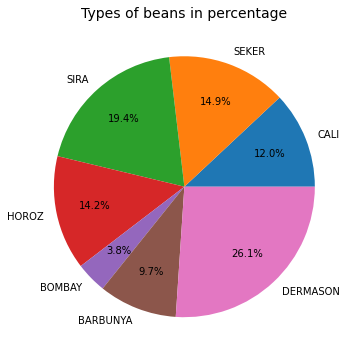

In [ ]:
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(labels=["CALI","SEKER","SIRA","HOROZ","BOMBAY","BARBUNYA","DERMASON"], autopct="%.1f%%",  x=[CALI,SEKER,SIRA,HOROZ,BOMBAY,BARBUNYA,DERMASON], pctdistance=0.7)
plt.title("Types of beans in percentage", fontsize=14);

Below graph shows each type of beans count.

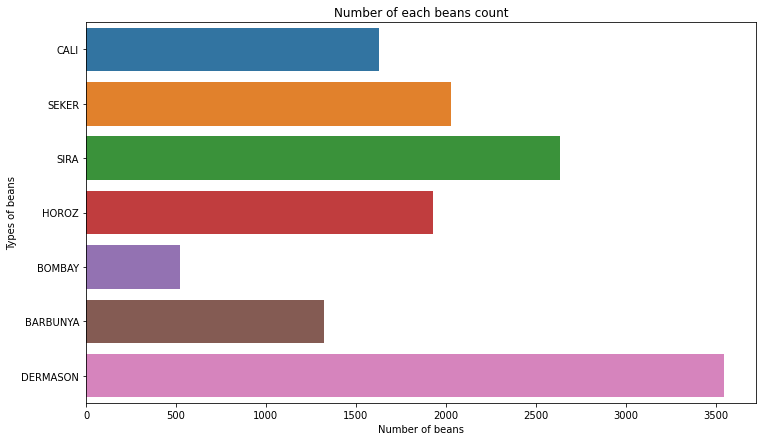

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

sns.barplot(x=[CALI,SEKER,SIRA,HOROZ,BOMBAY,BARBUNYA,DERMASON], y=["CALI","SEKER","SIRA","HOROZ","BOMBAY","BARBUNYA","DERMASON"])
ax.set(xlabel='Number of beans', ylabel='Types of beans')
ax.set_title('Number of each beans count')
plt.show()

Check if any columns of data contains null value.

In [ ]:
OD.select([count(when(isnull(c), c)).alias(c) for c in OD.columns]).show()

+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+
|Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|Extent|Solidity|roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+
|   0|        0|              0|              0|           0|           0|         0|            0|     0|       0|        0|          0|           0|           0|           0|           0|    0|
+----+---------+---------------+---------------+------------+------------+----------+-------------+------+--------+---------+-----------+------------+------------+------------+------------+-----+



## Data Preparation<a class="anchor" id="data_preparation"></a>

When we look at the correlation map, most correlated features is marked with dark blue and light blue(almost white). We can interpret correlation matrix in a way that if the values near to +1 or -1, between those features higly correlation exists and we should eliminate one of them. Otherwise if the values not near to +1 or -1 that correlation value can be negligible and we don't need to eliminate those features. 

So I will just keep one of the features and use it in machine learning algorithms, if any of the two features are high correlated.

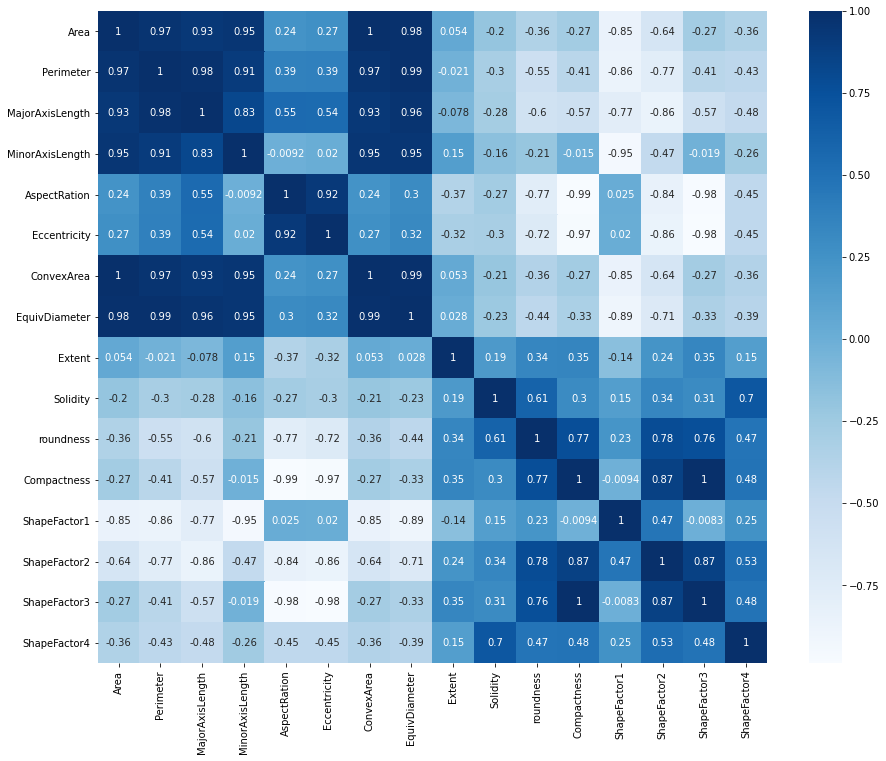

In [ ]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=OD.columns[:-1], outputCol=vector_col)
dataset_vector = assembler.transform(OD).select(vector_col)

matrix = Correlation.corr(dataset_vector, vector_col)
matrix = matrix.collect()[0]["pearson({})".format(vector_col)].toArray()

plt.figure(figsize=(15, 12))
sns.heatmap(matrix, annot=True, cmap="Blues",xticklabels=OD.columns[:-1], yticklabels=OD.columns[:-1]);

Eliminate one of the columns between any highly correlated columns(value>=0.95). In that case remaining columns selected below.

In [ ]:
OD = OD.select("Area","AspectRation","Eccentricity","Extent","Solidity","roundness","ShapeFactor1","ShapeFactor2","ShapeFactor4", "Class")

New correlation matrix after eliminating some of the features.

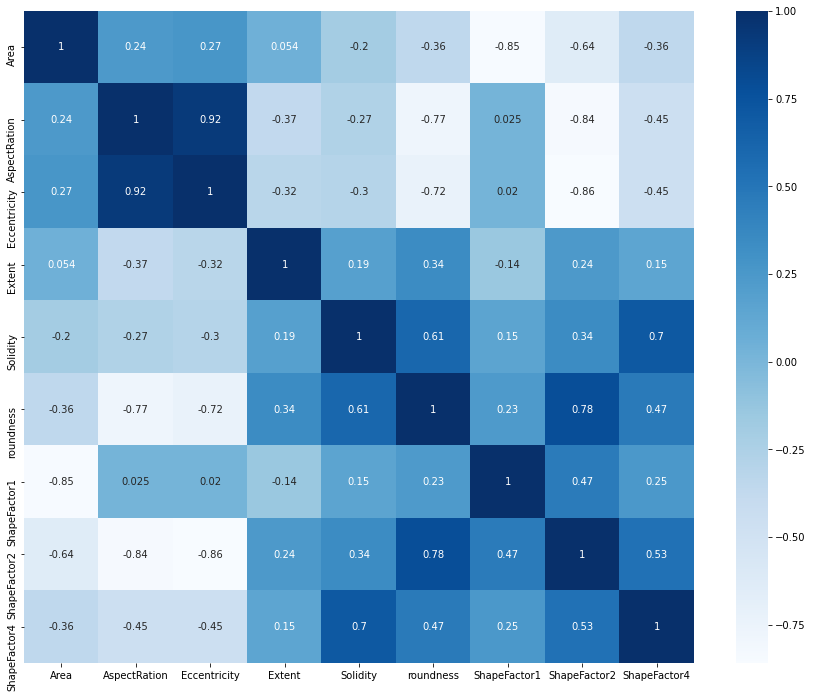

In [ ]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=OD.columns[:-1], outputCol=vector_col)
dataset_vector = assembler.transform(OD).select(vector_col)

matrix = Correlation.corr(dataset_vector, vector_col)
matrix = matrix.collect()[0]["pearson({})".format(vector_col)].toArray()

plt.figure(figsize=(15, 12))
sns.heatmap(matrix, annot=True, cmap="Blues",xticklabels=OD.columns[:-1], yticklabels=OD.columns[:-1]);

Map Class feature objects to numeric values.

In [ ]:
OD = OD.withColumn('Class', when(OD.Class == "SEKER", 0).when(OD.Class == "BARBUNYA", 1).when(OD.Class == "BOMBAY", 2).when(OD.Class == "CALI", 3).when(OD.Class == "DERMASON", 4).when(OD.Class == "HOROZ", 5).when(OD.Class == "SIRA", 6))

In [ ]:
OD.select('Class').distinct().show()

+-----+
|Class|
+-----+
|    1|
|    6|
|    3|
|    5|
|    4|
|    2|
|    0|
+-----+



Let's look at again what columns left after eliminating some of them and converting some of the types.

In [ ]:
OD.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: integer (nullable = true)



Before we put our data to machine learning algorithm we need to normalize it. I use min-max scaler for that purpose.
By using min-max scaler transform the data and save that data into a variable "ND".

In [ ]:
assembler = VectorAssembler(inputCols=OD.columns[:-1], outputCol="features")
OD = assembler.transform(OD)

scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
ND = scaler.fit(OD).transform(OD)

Let's finally look at the summary of data left after data preperation for normalized data and original data.

In [ ]:
OD.show(10)

+-----+------------+------------+-----------+-----------+-----------+------------+------------+------------+-----+--------------------+
| Area|AspectRation|Eccentricity|     Extent|   Solidity|  roundness|ShapeFactor1|ShapeFactor2|ShapeFactor4|Class|            features|
+-----+------------+------------+-----------+-----------+-----------+------------+------------+------------+-----+--------------------+
|28395| 1.197191424| 0.549812187|0.763922518|0.988855999|0.958027126| 0.007331506| 0.003147289| 0.998723889|    0|[28395.0,1.197191...|
|28734| 1.097356461| 0.411785251|0.783968133|0.984985603|0.887033637| 0.006978659| 0.003563624| 0.998430331|    0|[28734.0,1.097356...|
|29380| 1.209712656| 0.562727317|0.778113248|0.989558774|0.947849473| 0.007243912| 0.003047733| 0.999066137|    0|[29380.0,1.209712...|
|30008| 1.153638059| 0.498615976|0.782681273|0.976695743|0.903936374| 0.007016729| 0.003214562| 0.994198849|    0|[30008.0,1.153638...|
|30140|  1.06079802| 0.333679658|0.773098035| 0.

In [ ]:
ND.show(10)

+-----+------------+------------+-----------+-----------+-----------+------------+------------+------------+-----+--------------------+--------------------+
| Area|AspectRation|Eccentricity|     Extent|   Solidity|  roundness|ShapeFactor1|ShapeFactor2|ShapeFactor4|Class|            features|      scaledFeatures|
+-----+------------+------------+-----------+-----------+-----------+------------+------------+------------+-----+--------------------+--------------------+
|28395| 1.197191424| 0.549812187|0.763922518|0.988855999|0.958027126| 0.007331506| 0.003147289| 0.998723889|    0|[28395.0,1.197191...|[0.03405267382875...|
|28734| 1.097356461| 0.411785251|0.783968133|0.984985603|0.887033637| 0.006978659| 0.003563624| 0.998430331|    0|[28734.0,1.097356...|[0.03550017933696...|
|29380| 1.209712656| 0.562727317|0.778113248|0.989558774|0.947849473| 0.007243912| 0.003047733| 0.999066137|    0|[29380.0,1.209712...|[0.03825855266528...|
|30008| 1.153638059| 0.498615976|0.782681273|0.976695743|0

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

I did some research on the internet and decided to use k-means algorithm for clustering because K-Means is useful when we have an idea of how many clusters actually exists in our space. Its main benefit is its speed. Below I try to explain the parameters that I used.

**setK**--> sets k for the clustering step. This is the most important parameter for k-means. I set it to 7 as it mentioned on assignment paper.

**setSeed**--> Set the random seed for cluster initialization.

**max_iter** --> sets the number of maximum iterations for each initialization of the k-means algorithm. If we keep max_iter at a higher value, then we are guaranteed that we have explored the entire feature space. That's why I set it to 1000.

Kmeans clustering for Original Data.

In [ ]:
OD_evaluator = ClusteringEvaluator()

kmeans = KMeans(initMode = "k-means||").setK(7).setSeed(77).setFeaturesCol('features')
kmeans.setMaxIter(1000)
kmeans_model = kmeans.fit(OD.drop('Class'))

kmeans_predictions = kmeans_model.transform(OD.drop('Class'))

K-means clustering for Normalized Data.

In [ ]:
ND_evaluator = ClusteringEvaluator()

kmeans_normalized = KMeans(initMode = "k-means||").setK(7).setSeed(77).setFeaturesCol('scaledFeatures')
kmeans_normalized.setMaxIter(1000)
kmeans_normalized_model = kmeans_normalized.fit(ND.drop('Class'))

kmeans_normalized_predict = kmeans_normalized_model.transform(ND.drop('Class'))

Finding centers of the clusters for normalized data and original data.

In [ ]:
kmeans_centroid = np.array(kmeans_model.clusterCenters())
kmeans_normalized_centorid = np.array(kmeans_normalized_model.clusterCenters())


## Clustering results<a class="anchor" id="clustering"></a>

**Silhouette score** is measure to decide the number of clusters to be formulated from the data.

+1 Score = Near +1 Silhouette score indicates that the sample is far away from its neighboring cluster.

0 Score = 0 Silhouette score indicates that the sample is on or very close to the decision boundary separating two neighboring clusters.

-1 Score = 1 Silhouette score indicates that the samples have been assigned to the wrong clusters.

In [ ]:
OD_silhouette_score = OD_evaluator.evaluate(kmeans_predictions)
print("Silhouette score of model used original dataset: ", OD_silhouette_score)

ND_silhouette_score = ND_evaluator.evaluate(kmeans_normalized_predict)
print("Silhouette score of model used normalized dataset:", ND_silhouette_score)

Silhouette score of model used original dataset:  0.6962610039599201
Silhouette score of model used normalized dataset: 0.019428594512056144


Let's check K-means cost (sum of squared distances to the nearest centroid for all points in the training dataset). This is equivalent to sklearn's inertia value.

In [ ]:
print("Cost for original data training cost: ",kmeans_model.summary.trainingCost)
print("Cost for normalized data training cost: ",kmeans_normalized_model.summary.trainingCost)

Cost for original data training cost:  353091582815.18726
Cost for normalized data training cost:  593.896523998486


The K-means algorithm aims to choose centroids that minimise the inertia. Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. Based on the below calculations we can say that normalized data gave better results.

Here are the clustering result you can see below. For the convention and the size of the file I've listed four comparison.

First graph represent the actual clusters.

Second graph represents original data by using k-means algorithm without normalization by dropping the class feature from the original data.

Third graph represents normalized data(using min-max scaling) by using k-means algorithm also dropping the class feature.

Black dots represent the centroids. It is basically at the center of a cluster.

In conlcusion from the training cost(inertia values in skleran metrics) values we can say that normalized data gives better result as it can be seen below graphs.

In [ ]:
Scale_feature = kmeans_normalized_predict.select('scaledFeatures').rdd.map(lambda x: x[0]).collect()

This function get normalized values from ScaledFeatures column in ND dataset.

In [ ]:
def getIndex(index1,myList):
  result = []
  for row in myList:
    result.append(row[index1])
  return result

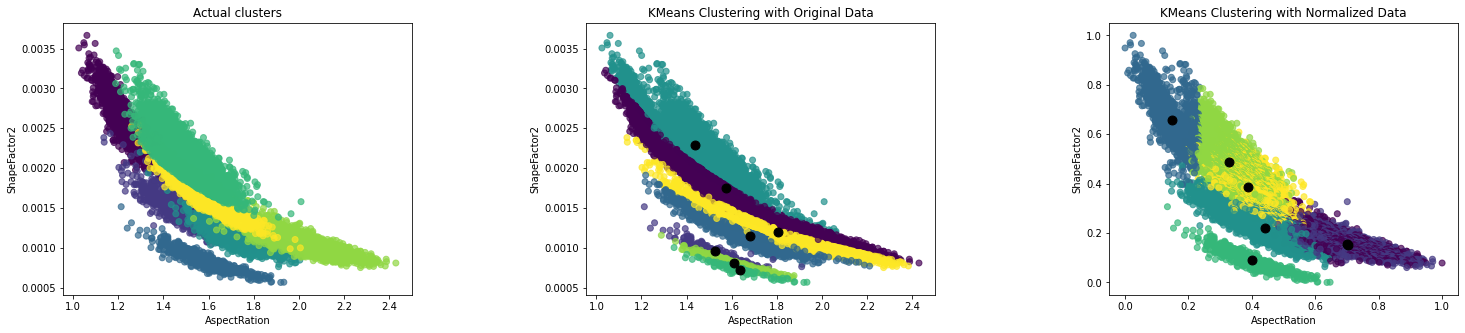

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
fig.subplots_adjust(wspace=0.5)

ax1.scatter(kmeans_predictions.select('AspectRation').collect(), kmeans_predictions.select('ShapeFactor2').collect(), c=OD.select("Class").collect(), alpha=0.7)
ax1.set(xlabel='AspectRation', ylabel='ShapeFactor2')
ax1.set_title("Actual clusters")

ax2.scatter(kmeans_predictions.select('AspectRation').collect(), kmeans_predictions.select('ShapeFactor2').collect(), c=kmeans_predictions.select('prediction').collect(),alpha=0.7)
ax2.scatter(kmeans_centroid[:,1] , kmeans_centroid[:,7] , s = 80, color = 'k')
ax2.set(xlabel='AspectRation', ylabel='ShapeFactor2')
ax2.set_title("KMeans Clustering with Original Data")

ax3.scatter(getIndex(1,Scale_feature), getIndex(7,Scale_feature), c=kmeans_normalized_predict.select('prediction').collect(),alpha=0.7)
ax3.scatter(kmeans_normalized_centorid[:,1] , kmeans_normalized_centorid[:,7] , s = 80, color = 'k')
ax3.set(xlabel='AspectRation', ylabel='ShapeFactor2')
ax3.set_title("KMeans Clustering with Normalized Data");


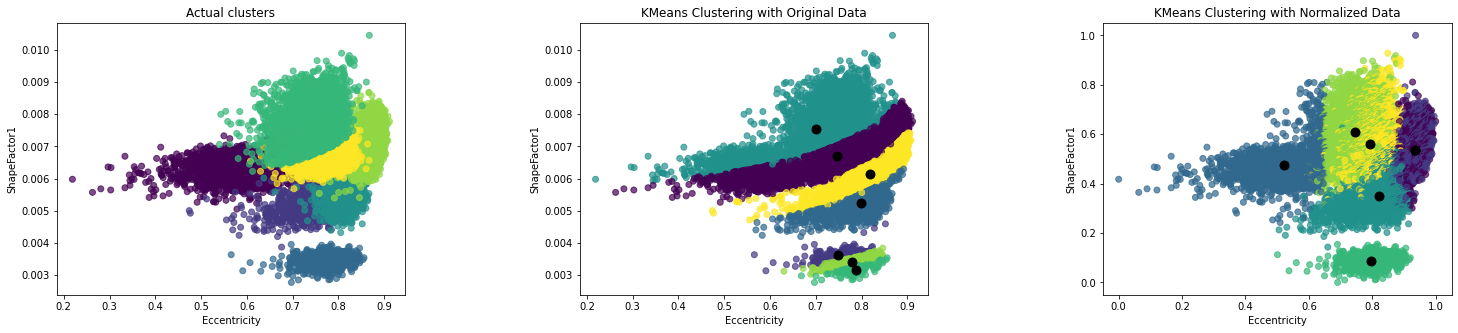

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
fig.subplots_adjust(wspace=0.5)

ax1.scatter(kmeans_predictions.select('Eccentricity').collect(), kmeans_predictions.select('ShapeFactor1').collect(), c=OD.select("Class").collect(), alpha=0.7)
ax1.set(xlabel='Eccentricity', ylabel='ShapeFactor1')
ax1.set_title("Actual clusters")

ax2.scatter(kmeans_predictions.select('Eccentricity').collect(), kmeans_predictions.select('ShapeFactor1').collect(), c=kmeans_predictions.select('prediction').collect(),alpha=0.7)
ax2.scatter(kmeans_centroid[:,2] , kmeans_centroid[:,6] , s = 80, color = 'k')
ax2.set(xlabel='Eccentricity', ylabel='ShapeFactor1')
ax2.set_title("KMeans Clustering with Original Data")

ax3.scatter(getIndex(2,Scale_feature), getIndex(6,Scale_feature), c=kmeans_normalized_predict.select('prediction').collect(),alpha=0.7)
ax3.scatter(kmeans_normalized_centorid[:,2] , kmeans_normalized_centorid[:,6] , s = 80, color = 'k')
ax3.set(xlabel='Eccentricity', ylabel='ShapeFactor1')
ax3.set_title("KMeans Clustering with Normalized Data");


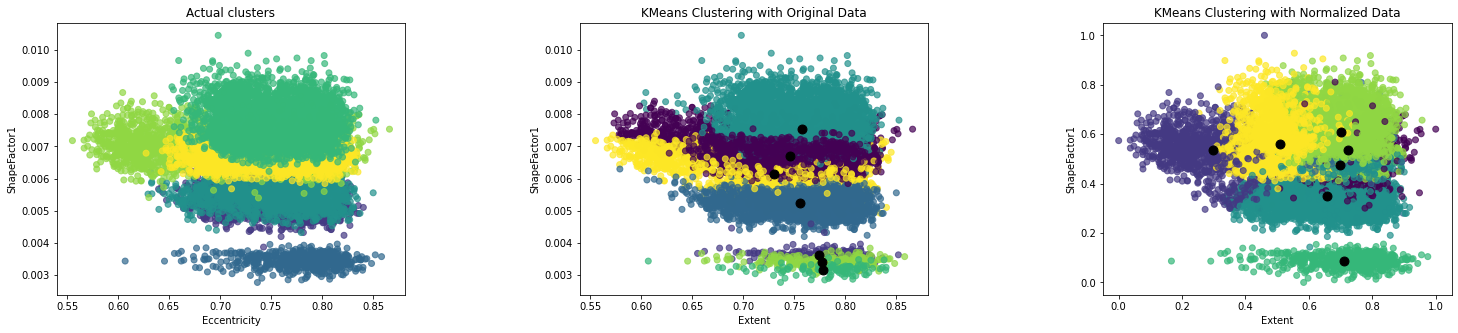

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
fig.subplots_adjust(wspace=0.5)

ax1.scatter(kmeans_predictions.select('Extent').collect(), kmeans_predictions.select('ShapeFactor1').collect(), c=OD.select("Class").collect(), alpha=0.7)
ax1.set(xlabel='Eccentricity', ylabel='ShapeFactor1')
ax1.set_title("Actual clusters")

ax2.scatter(kmeans_predictions.select('Extent').collect(), kmeans_predictions.select('ShapeFactor1').collect(), c=kmeans_predictions.select('prediction').collect(),alpha=0.7)
ax2.scatter(kmeans_centroid[:,3] , kmeans_centroid[:,6] , s = 80, color = 'k')
ax2.set(xlabel='Extent', ylabel='ShapeFactor1')
ax2.set_title("KMeans Clustering with Original Data")

ax3.scatter(getIndex(3,Scale_feature), getIndex(6,Scale_feature), c=kmeans_normalized_predict.select('prediction').collect(),alpha=0.7)
ax3.scatter(kmeans_normalized_centorid[:,3] , kmeans_normalized_centorid[:,6] , s = 80, color = 'k')
ax3.set(xlabel='Extent', ylabel='ShapeFactor1')
ax3.set_title("KMeans Clustering with Normalized Data");

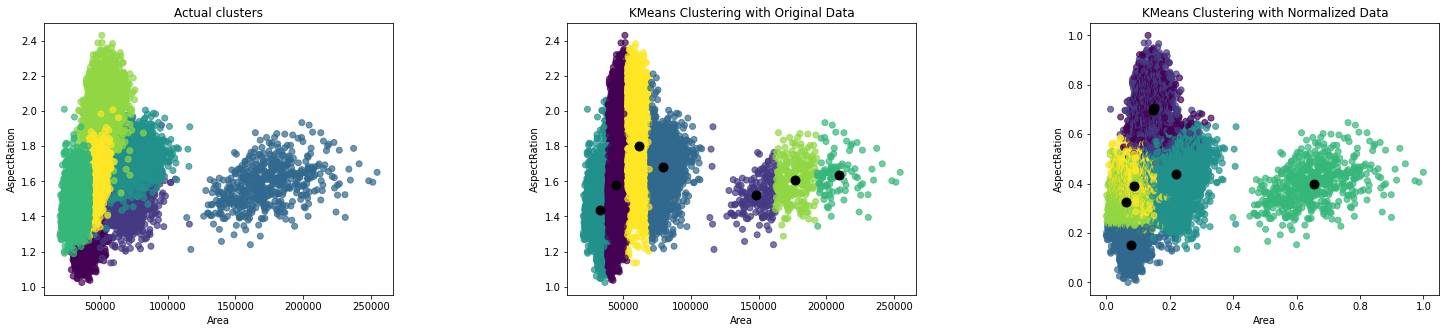

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))
fig.subplots_adjust(wspace=0.5)

ax1.scatter(kmeans_predictions.select('Area').collect(), kmeans_predictions.select('AspectRation').collect(), c=OD.select("Class").collect(), alpha=0.7)
ax1.set(xlabel='Area', ylabel='AspectRation')
ax1.set_title("Actual clusters")

ax2.scatter(kmeans_predictions.select('Area').collect(), kmeans_predictions.select('AspectRation').collect(), c=kmeans_predictions.select('prediction').collect(),alpha=0.7)
ax2.scatter(kmeans_centroid[:,0] , kmeans_centroid[:,1] , s = 80, color = 'k')
ax2.set(xlabel='Area', ylabel='AspectRation')
ax2.set_title("KMeans Clustering with Original Data")

ax3.scatter(getIndex(0,Scale_feature), getIndex(1,Scale_feature), c=kmeans_normalized_predict.select('prediction').collect(),alpha=0.7)
ax3.scatter(kmeans_normalized_centorid[:,0] , kmeans_normalized_centorid[:,1] , s = 80, color = 'k')
ax3.set(xlabel='Area', ylabel='AspectRation')
ax3.set_title("KMeans Clustering with Normalized Data");


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

Based on the research I did on the internet I decided to use Multinomial Logistic Regression model because of several reasons that could be find on following link. [Multinomial Logistic Regression](https://statistics.laerd.com/spss-tutorials/multinomial-logistic-regression-using-spss-statistics.php#:~:text=Multinomial%20logistic%20regression%20(often%20just,with%20more%20than%20two%20categories.) 

Multinomial logistic regression is a form of logistic regression used to predict a target variable have more than 2 classes.



Let's start with defining evaluator for our model.

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="accuracy")

Splitting data to train dataset and test dataset.

In [ ]:
(OD_train_set, OD_test_set) = OD.randomSplit([0.7, 0.3])

Normalizing the original data and prepare train and test datasets for normalized data.

In [ ]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

ND_train_set = scaler.fit(OD_train_set).transform(OD_train_set)
ND_test_set = scaler.fit(OD_test_set).transform(OD_test_set)

I will try to explain the parameters that I used in Logistic Regression model.

**family -->** The name of family which is a description of the label distribution to be used in the model. Since our Class field is multi class we will use multinomial option.

**elasticNetParam -->** For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. Since our Class field is multi class only L2 penalty gives better result and used for multinomial option.

**maxIter -->** max number of Iteration. We need to give higher value to maxIter if we want better results however it takes a lot of time to compute it. Due to those reasons i took value of 1000.

**regParam -->** Specifically, this param is used (in Spark ML) for L2 regularization, which reduces the chance of overfitting by penalizing models for being too complex. 

**labelCol -->** label column name.

**featuresCol -->** features column name.

**CrossValidator -->** CrossValidator begins by splitting the dataset into a set of folds which are used as separate training and test datasets. E.g., with numFolds=3 folds, CrossValidator will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. I used 5 for this parameter to get better result.

Actually I tried grid search for finding best paramaters however it took almost 30 minutes for execution. That's why I removed it from the code.

In [ ]:
model = LogisticRegression(family="multinomial",featuresCol='features', labelCol='Class',elasticNetParam=0,maxIter=1000,regParam=0.01)

lr_cv = CrossValidator(estimator=model, evaluator=evaluator, numFolds=5)

lrModel = model.fit(OD_train_set)
lrModel_predictions = lrModel.transform(OD_test_set)

In [ ]:
model_normalized = LogisticRegression(family="multinomial",featuresCol='features', labelCol='Class',elasticNetParam=0,maxIter=1000,regParam=0.01)

lr_cv_normalized = CrossValidator(estimator=model_normalized, evaluator=evaluator, numFolds=5)

lrModelNormalized = model_normalized.fit(ND_train_set)
lrModelNormalized_predictions = lrModelNormalized.transform(ND_test_set)

## Evaluation<a class="anchor" id="evaluation"></a>

**Interpreting the Classification Report**

TN / True Negative: the case was negative and predicted negative

TP / True Positive: the case was positive and predicted positive

FN / False Negative: the case was positive but predicted negative

FP / False Positive: the case was negative but predicted positive

The **recall** means "What percent of our predictions were correct"
Recall is the ability of a classifier to find all positive instances
Recall = TP/(TP+FN)

The **precision** will be "What percent of the positive cases did we catch". Precision is the ability of a classifier not to label an instance positive that is actually negative
Precision = TP/(TP + FP)

The **f1-score** means "What percent of our positive predictions were correct". The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0
F1 Score = 2*(Recall * Precision) / (Recall + Precision)

The **support** is the number of occurence of the given class in your dataset.

The **macro-average** precision and recall score is calculated as arithmetic mean of individual classes’ precision and recall scores.

The **macro-average** F1-score is calculated as arithmetic mean of individual classes’ F1-score.

R^2 score for original data.

In [ ]:
evaluator.evaluate(lrModel_predictions)

0.9110363068045203

Classification Report for original data

In [ ]:
print(classification_report(lrModel_predictions.select(['Class']).collect(), lrModel_predictions.select(['prediction']).collect()))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       578
           1       0.94      0.89      0.91       418
           2       1.00      0.99      0.99       157
           3       0.93      0.93      0.93       502
           4       0.91      0.91      0.91      1078
           5       0.94      0.95      0.94       593
           6       0.84      0.86      0.85       833

    accuracy                           0.91      4159
   macro avg       0.93      0.92      0.92      4159
weighted avg       0.91      0.91      0.91      4159



Below you can see the confusion matrix for original data. The diagonal elements represent the total correct values predicted per class.

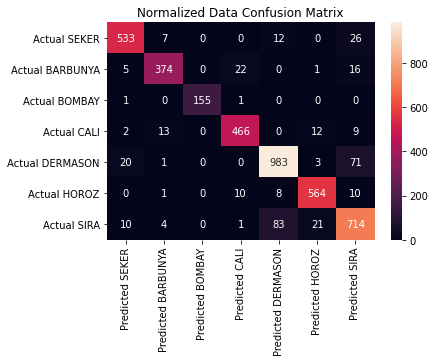

In [ ]:
result = confusion_matrix(lrModel_predictions.select(['Class']).collect(), lrModel_predictions.select(['prediction']).collect())
sns.heatmap(result, annot=True,fmt='d',xticklabels=['Predicted SEKER', 'Predicted BARBUNYA','Predicted BOMBAY','Predicted CALI','Predicted DERMASON','Predicted HOROZ','Predicted SIRA'], 
            yticklabels=['Actual SEKER', 'Actual BARBUNYA','Actual BOMBAY','Actual CALI','Actual DERMASON','Actual HOROZ','Actual SIRA'])
plt.yticks(rotation=0)
plt.title('Normalized Data Confusion Matrix');

By looking at the confusion matrix we can say our model predict %100 percent correct for "BOMBAY" class, however that class has least number of samples either. Moreover we may say for the class "SIRA" we got highest wrong predictions among the others in total however number of samples looks higher than other classes except "DERMASON" class.

R^2 score for normalized data.

In [ ]:
evaluator.evaluate(lrModelNormalized_predictions)

0.9110363068045203

Classification Report for normalized data

In [ ]:
print(classification_report(lrModelNormalized_predictions.select(['Class']).collect(), lrModelNormalized_predictions.select(['prediction']).collect()))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       578
           1       0.94      0.89      0.91       418
           2       1.00      0.99      0.99       157
           3       0.93      0.93      0.93       502
           4       0.91      0.91      0.91      1078
           5       0.94      0.95      0.94       593
           6       0.84      0.86      0.85       833

    accuracy                           0.91      4159
   macro avg       0.93      0.92      0.92      4159
weighted avg       0.91      0.91      0.91      4159



Below you can see the confusion matrix for normalized data. The diagonal elements represent the total correct values predicted per class.

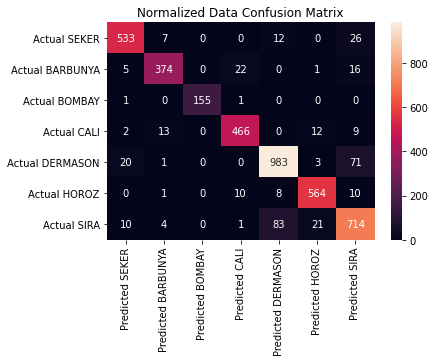

In [ ]:
result = confusion_matrix(lrModelNormalized_predictions.select(['Class']).collect(), lrModelNormalized_predictions.select(['prediction']).collect())
sns.heatmap(result, annot=True, xticklabels=['Predicted SEKER', 'Predicted BARBUNYA','Predicted BOMBAY','Predicted CALI','Predicted DERMASON','Predicted HOROZ','Predicted SIRA'], 
            yticklabels=['Actual SEKER', 'Actual BARBUNYA','Actual BOMBAY','Actual CALI','Actual DERMASON','Actual HOROZ','Actual SIRA'],
         fmt='d')
plt.yticks(rotation=0)
plt.title('Normalized Data Confusion Matrix');


By looking at the confusion matrix we can say our model predict %100 percent correct for "BOMBAY" class, however that class has least number of samples either. Moreover we may say for the class "SIRA" we got highest wrong predictions among the others in total however number of samples looks higher than other classes except "DERMASON" class.

## References<a class="anchor" id="references"></a>

[1] https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame

[2] https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark

[3] https://spark.apache.org/docs/latest/ml-clustering.html

[4] https://rsandstroem.github.io/sparkkmeans.html

[5] https://www.bmc.com/blogs/python-spark-k-means-example/

[6] https://spark.apache.org/docs/2.2.1/api/java/org/apache/spark/mllib/clustering/KMeans.html

[7] https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark

[8] https://spark.apache.org/docs/latest/ml-classification-regression.html

[9] https://runawayhorse001.github.io/LearningApacheSpark/classification.html

[10]https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html#pyspark.ml.classification.LogisticRegression.thresholds

[11] https://spark.apache.org/docs/1.6.0/mllib-evaluation-metrics.html

[12] https://towardsdatascience.com/transfer-learning-with-pyspark-729d49604d45

[13] https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397

[14] https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/

[15] https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397

[16] https://stackoverflow.com/questions/22496689/when-to-use-k-means-clustering-algorithm/22497054#:~:text=K%2DMeans%20is%20useful%20when,of%20observations%20in%20your%20dataset.


**Disclaimer!** <font color='grey'>This notebook was prepared by <student name(s)> as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>